In [3]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import sqlalchemy as db
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *

np.seterr(divide = 'ignore')
pd.set_option('display.max_rows', 500)

In [4]:
load_dotenv()

# config and credentials
server = os.getenv('server')
database = os.getenv('database')
username = os.getenv('username')
password = os.getenv('password')

# connection
engine = db.create_engine(
    'mssql://{}:{}@{}/{}?driver=ODBC+Driver+18+for+SQL+Server'.format(
        username, password, server, database
    )
)

# establish connection
connection = engine.connect()

In [18]:
def get_sample_particulars(df):
    print('Number of observations: {:,}'.format(len(df.index)))
    print('Returns: Mean: {:.5f} | Median: {:.5f} | Std returns: {:.5f}'.format(
        100 * df['R'].mean(), 100 * df['R'].median(), df['R'].std()))
    print('Volume mean: {:.5f}'.format(df['Volume'].mean()))
    print('Coupon mean: {:.5f}'.format(df['Coupon'].mean()))

### Query Selection

In [26]:
volume_range_start = 100000
volume_range_end = 1000000
holding_period = 6


query = '''
    DECLARE @RC int
    DECLARE @VolumeRangeStart int
    DECLARE @VolumeRangeEnd int
    DECLARE @HoldingPeriod int

    SET @VolumeRangeStart = {}
    SET @VolumeRangeEnd = {}
    SET @HoldingPeriod = {}

    EXECUTE @RC = [dbo].[Momentum_VolumeGroups] 
       @VolumeRangeStart,
       @VolumeRangeEnd,
       @HoldingPeriod
'''.format(
    volume_range_start,
    volume_range_end,
    holding_period
)

# read sql
# df = pd.read_sql(query, connection)
# df.to_csv('data/output/bonds/momentum_{}-{}.csv'.format(volume_range_start, volume_range_end), index=False)

In [40]:
# read csv
df = pd.read_csv('data/output/bonds/momentum_{}-{}.csv'.format(volume_range_start, volume_range_end))

# date transformation
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['MonthGap'] == 1]

# select columns
df = df[['CusipId', 'Date', 'Coupon', 'Volume', 'R']]
df.columns = ['Cusip', 'Date', 'Coupon', 'Volume', 'R']

### Quantile Filtering and Outlier Visualization

In [41]:
df['quantiles'] = pd.qcut(df.R, np.linspace(0, 1, 201), labels=np.linspace(0, 1, 200)).astype(float)
df['outliers'] = np.where((df['quantiles'] > 0.995) | (df['quantiles'] < 0.005), 1, 0)
df['Year'] = df['Date'].dt.year

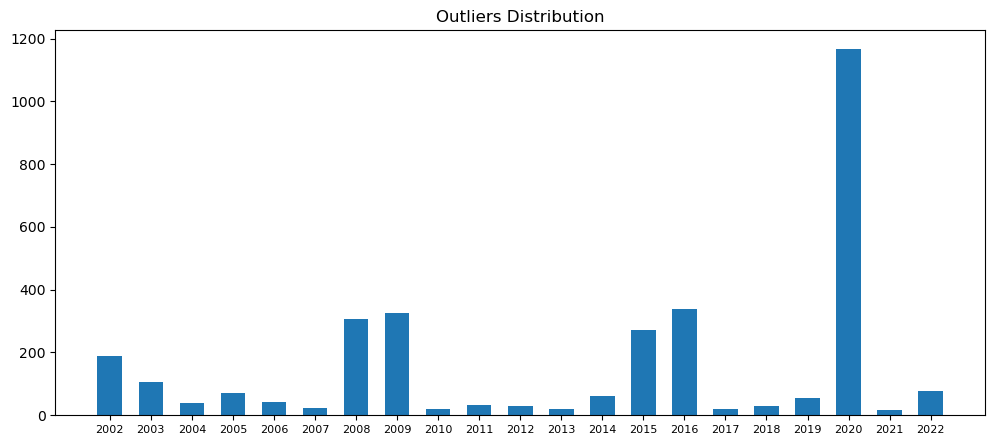

In [42]:
df_g = df.groupby('Year')['outliers'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.title('Outliers Distribution')
plt.bar(df_g['Year'], df_g['outliers'], width = 0.6)
plt.xticks([i for i in range(2002, 2023)], fontsize=8)
plt.show()

In [43]:
# filter out outliers
df = df[df['outliers'] == 0]

### Exploratory Analysis

In [44]:
df['Cusip'].nunique()

14798

In [ ]:
# number of entries
# df['RatingClass'].value_counts(dropna=False)

In [ ]:
# number of distinct Cusips
# df.groupby('RatingClass', dropna=False).Cusip.nunique()

In [ ]:
# drop NR
# df = df.dropna(subset=['RatingNum'])

# number of entries
# df['MaturityBand'].value_counts(dropna=False)

In [ ]:
# number of distinct Cusips
# df.groupby('MaturityBand').Cusip.nunique()

In [ ]:
# df['Cusip'].nunique()

In [ ]:
# filtering
# df = df[df['MaturityBand'] == 1]
# df = df[df['RatingClass'] == '1.HY']

In [27]:
get_sample_particulars(df)

Number of observations: 476,259
Returns: Mean: 0.01106 | Median: 0.00000 | Std returns: 0.12006
Volume mean: 651242.12638
Coupon mean: 4.85490


### Portfolio Analysis

In [45]:
# fill NULL returns
df['R'] = df['R'].fillna(0)

# log returns
df['logR'] = np.log(1 + df['R'])

In [46]:
J = 6 # formation period

df_ = df[
    ['Cusip', 'Date', 'R', 'logR']
].sort_values(['Cusip', 'Date']).set_index('Date')

cumr = df_.groupby(['Cusip'])['logR'].rolling(J, min_periods=J).sum().reset_index()
cumr = cumr.rename(columns = {'logR': 'SumLogR'})

cumr['CumRet'] = np.exp(cumr['SumLogR'])-1

In [47]:
r = 10 # momentum ranking

cumr = cumr.dropna(axis=0, subset=['CumRet'])

cumr['MomR'] = cumr.groupby('Date')['CumRet'].transform(lambda x: pd.qcut(x, r, labels=False))
cumr['MomR'] = 1 + cumr['MomR'].astype(int)

In [48]:
cumr.groupby('MomR')['CumRet'].mean()

MomR
1    -0.080689
2    -0.036793
3    -0.022949
4    -0.013868
5    -0.006124
6     0.001736
7     0.010675
8     0.022181
9     0.039791
10    0.086483
Name: CumRet, dtype: float64

In [49]:
K = 1 # Holding Period Length: K can be between 3 to 12 months

cumr['form_date'] = cumr['Date']
cumr['medate'] = cumr['Date'] + MonthEnd(0)
cumr['hdate1'] = cumr['medate'] + MonthBegin(1)
cumr['hdate2'] = cumr['medate'] + MonthEnd(K)
cumr = cumr[['Cusip', 'form_date','MomR','hdate1','hdate2']]

port = pd.merge(df[['Cusip', 'Date', 'R']], cumr, on=['Cusip'], how='inner')
port = port[(port['hdate1'] <= port['Date']) & (port['Date'] <= port['hdate2'])]
port = port[['Cusip','form_date', 'MomR', 'hdate1','hdate2', 'Date', 'R']]
port['Date'] = pd.to_datetime(port['Date'])

In [50]:
cumr_port = port.groupby(['Date','MomR', 'form_date'])['R'].mean().reset_index()

start_yr = cumr_port['Date'].dt.year.min() + 2
cumr_port = cumr_port.loc[cumr_port.Date.dt.year >= start_yr]
cumr_port = cumr_port.sort_values(by=['Date','MomR'])

ewret = cumr_port.groupby(['Date','MomR'])['R'].mean().reset_index()
ewstd = cumr_port.groupby(['Date','MomR'])['R'].std().reset_index()

ewret = ewret.rename(columns={'R':'ewret'})
ewstd = ewstd.rename(columns={'R':'ewretstd'})

ewretdf = pd.merge(ewret, ewstd, on=['Date','MomR'], how='inner')
ewretdf = ewretdf.sort_values(by=['MomR', 'Date'])

In [51]:
ewretdf.groupby(['MomR'])['ewret'].describe()[['count','mean', 'std']].reset_index()

,MomR,count,mean,std
0,1,213.0,0.000012,0.022892
1,2,213.0,-0.000566,0.016701
2,3,213.0,-0.000637,0.013863
3,4,213.0,-0.000550,0.012102
4,5,213.0,-0.000620,0.010614
5,6,213.0,-0.000601,0.010218
6,7,213.0,-0.000383,0.010316
7,8,213.0,0.000039,0.011437
8,9,213.0,0.000447,0.013185
9,10,213.0,0.000369,0.016477


In [52]:
ewret_t = ewretdf.pivot(index='Date', columns='MomR', values='ewret') 

# Add prefix port in front of each column 
ewret_t = ewret_t.add_prefix('port') 
ewret_t = ewret_t.rename(columns={'port1':'losers', 'port10':'winners'}) 
ewret_t['long_short'] = ewret_t.winners - ewret_t.losers
ewret_t.head()

MomR,losers,port2,port3,port4,port5,port6,port7,port8,port9,winners,long_short
Date,,,,,,,,,,,
2005-01-31,-0.006285,-0.004226,-0.003305,-0.001452,-0.002475,-0.002302,0.001014,0.002941,-0.002393,-0.003981,0.002303
2005-02-28,-0.009372,-0.005872,-0.006034,-0.004146,-0.006900,-0.006974,-0.008606,-0.008316,-0.006524,-0.010141,-0.000768
2005-03-31,-0.046713,-0.020279,-0.009275,-0.010314,-0.019783,-0.014125,-0.015195,-0.022139,-0.032841,-0.038696,0.008018
2005-04-30,-0.036472,-0.006073,0.004854,0.002490,0.005998,0.002945,0.004665,0.003097,0.003255,0.002812,0.039284
2005-05-31,0.018125,0.013459,0.006034,0.002614,0.001583,0.003683,0.005854,0.005741,0.007967,0.011240,-0.006885


In [53]:
ewret_t['cumret_winners'] = (1 + ewret_t.winners).cumprod() - 1 
ewret_t['cumret_losers'] = (1 + ewret_t.losers).cumprod() - 1
ewret_t['cumret_long_short'] = (1 + ewret_t.long_short).cumprod() - 1

mom_mean = ewret_t[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()
mom_mean

,MomR,mean
0,winners,0.000369
1,losers,0.000012
2,long_short,0.000357


In [54]:
t_losers = pd.Series(stats.ttest_1samp(ewret_t['losers'], 0.0, nan_policy='omit')).to_frame().T 
t_winners = pd.Series(stats.ttest_1samp(ewret_t['winners'], 0.0, nan_policy='omit')).to_frame().T 
t_long_short = pd.Series(stats.ttest_1samp(ewret_t['long_short'], 0.0, nan_policy='omit')).to_frame().T

t_losers['MomR'] = 'losers'
t_winners['MomR'] = 'winners'
t_long_short['MomR'] = 'long_short'

In [55]:
t_output = pd.concat([t_winners, t_losers, t_long_short]).rename(columns={0:'t-stat', 1:'p-value'}) 

# Combine mean, t and p and format output 
mom_output = pd.merge(mom_mean, t_output, on=['MomR'], how='inner')

mom_output['mean'] = mom_output['mean'].map('{:.2%}'.format) 
mom_output['t-stat'] = mom_output['t-stat'].map('{:.2f}'.format) 
mom_output['p-value'] = mom_output['p-value'].map('{:.2f}'.format) 

print('Momentum Strategy Summary:\n\n', mom_output)

Momentum Strategy Summary:

          MomR   mean t-stat p-value
0     winners  0.04%   0.33    0.74
1      losers  0.00%   0.01    0.99
2  long_short  0.04%   0.34    0.74


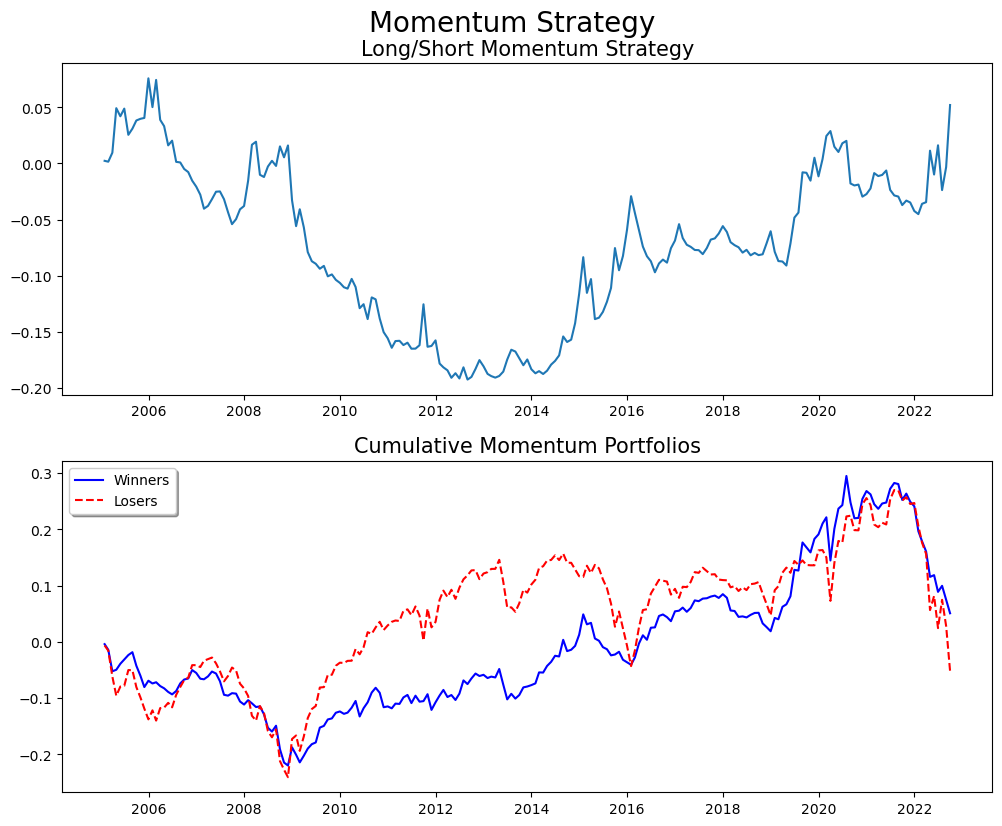

In [56]:
plt.figure(figsize=(12,9)) 
plt.suptitle('Momentum Strategy', fontsize=20) 

ax1 = plt.subplot(211) 
ax1.set_title('Long/Short Momentum Strategy', fontsize=15) 
ax1.plot(ewret_t['cumret_long_short']) 

ax2 = plt.subplot(212) 
ax2.set_title('Cumulative Momentum Portfolios', fontsize=15) 
ax2.plot(ewret_t['cumret_winners'], 'b-', ewret_t['cumret_losers'], 'r--') 
ax2.legend(('Winners','Losers'), loc='upper left', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)